# Requirements

In [1]:
# Add as many imports as you need.
import pandas as pd
from transformers import pipeline

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **close price** of the Dow Jones Industrial Average index. To accomplish this use data from the past 7 days, which includes numeric information and news information. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast one future step for the index price (the following day).


## The DIJA Dataset

This dataset consists of daily price records for the value of the Dow Jones Industrial Average index. The dataset includes the following attributes:

- Date - date in the format YYYY-MM-DD,
- Open - open price of the index on the specified date
- Close - close price of the index on the specified date
- High - high price of the index on the specified date
- Low - low price of the index on the specified date
- Volume - number of trades



## The Reddit News Dataset

This dataset consists of news headlines for a certain date that might impact the price:

- Date - date in the format YYYY-MM-DD,
- News - news headline scraped from Reddit

<b>Note: You might have multiple headlines for each date. The number of news per date might not be the same for each date. <b>

Load the datasets into a `pandas` data frame.

In [2]:
# Write your code here. Add as many boxes as you need.
dtable_data = pd.read_csv('DJIA_table.csv')

In [3]:
dtable_data['Date'] = pd.to_datetime(dtable_data['Date'])

In [4]:
news_data = pd.read_csv('RedditNews.csv')

In [5]:
news_data['Date'] = pd.to_datetime(news_data['Date'])

In [6]:
dtable_data.head()

,Date,Open,High,Low,Close,Volume
0,2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000
1,2016-06-30,17712.75977,17930.60938,17711.80078,17929.99023,133030000
2,2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000
3,2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000
4,2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000


In [7]:
news_data.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


Merge the datasets (be careful you can get multiple rows per date which is not desirable)

In [8]:
# Write your code here. Add as many boxes as you need.
news_grouped = news_data.groupby('Date')['News'].apply(lambda x: ' '.join(x)).reset_index()

In [9]:
merged_data = pd.merge(dtable_data, news_grouped, on='Date', how='inner')
merged_data.head()

,Date,Open,High,Low,Close,Volume,News
0,2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000,A 117-year-old woman in Mexico City finally re...
1,2016-06-30,17712.75977,17930.60938,17711.80078,17929.99023,133030000,Jamaica proposes marijuana dispensers for tour...
2,2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000,Explosion At Airport In Istanbul Yemeni former...
3,2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000,"2,500 Scientists To Australia: If You Want To ..."
4,2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000,Barclays and RBS shares suspended from trading...


## Feauture Extraction


1. DIJA Table
Apply a lag of one, up to 7 days to each feature, creating a set of features representing the index price from the previous 7 days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

2. Reddit News Table
Create a numeric representation for the news (for example average embedding or average sentiment). <b> You must create lags of the news features as well since we will not know the news for the future. </b>

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [10]:
dtable_data=dtable_data.drop(columns=['Date'])

In [11]:
# Write your code here. Add as many boxes as you need.
for lag in range(1,8):
    for col in dtable_data.columns:
        merged_data[f'{col}_lag{lag}'] = merged_data[col].shift(lag)
merged_data = merged_data.dropna().reset_index(drop=True)

In [12]:
sentiment_analyzer = pipeline('sentiment-analysis',device=0)
merged_data['News_Sentiment'] = merged_data['News'].apply(
    lambda x: sentiment_analyzer(x, truncation=True, max_length=512)[0]['score']
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [13]:
for lag in range(1,8):
    merged_data[f'New_Sentiment_lag{lag}'] = merged_data['News_Sentiment'].shift(lag)
merged_data = merged_data.dropna().reset_index(drop=True)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [19]:
# Write your code here. Add as many boxes as you need.
features = merged_data.drop(columns=['Date','Open','High','Low','Volume','Close', 'News', 'News_Sentiment'])
target = merged_data['Close']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [21]:
X_train

,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,...,Low_lag7,Close_lag7,Volume_lag7,New_Sentiment_lag1,New_Sentiment_lag2,New_Sentiment_lag3,New_Sentiment_lag4,New_Sentiment_lag5,New_Sentiment_lag6,New_Sentiment_lag7
0,17710.76953,17733.91992,17595.78906,17674.82031,93740000.0,17703.65039,17762.96094,17629.00977,17640.16992,94130000.0,...,17770.35938,17780.83008,89440000.0,0.991829,0.989460,0.993334,0.996921,0.997005,0.998601,0.982631
1,17830.50000,17893.27930,17731.34961,17732.48047,101690000.0,17710.76953,17733.91992,17595.78906,17674.82031,93740000.0,...,17799.80078,17829.73047,85130000.0,0.993033,0.991829,0.989460,0.993334,0.996921,0.997005,0.998601
2,17938.82031,17938.82031,17812.33984,17865.33984,90540000.0,17830.50000,17893.27930,17731.34961,17732.48047,101690000.0,...,17736.86914,17804.86914,99380000.0,0.995395,0.993033,0.991829,0.989460,0.993334,0.996921,0.997005
3,17969.98047,18005.22070,17915.88086,17985.18945,69690000.0,17938.82031,17938.82031,17812.33984,17865.33984,90540000.0,...,17602.77930,17675.16016,248680000.0,0.998964,0.995395,0.993033,0.991829,0.989460,0.993334,0.996921
4,17931.91016,18016.00000,17931.91016,18005.05078,71260000.0,17969.98047,18005.22070,17915.88086,17985.18945,69690000.0,...,17471.28906,17733.09961,91950000.0,0.993949,0.998964,0.995395,0.993033,0.991829,0.989460,0.993334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,10611.76953,10644.95020,10594.83984,10624.69043,166140000.0,10623.41016,10644.19043,10570.50977,10642.15039,160570000.0,...,10695.12988,10785.88965,157200000.0,0.997633,0.998095,0.997214,0.989274,0.990978,0.998664,0.998984
1576,10560.98047,10611.83984,10507.16992,10611.83984,150000000.0,10611.76953,10644.95020,10594.83984,10624.69043,166140000.0,...,10694.21973,10741.98047,434190000.0,0.998543,0.997633,0.998095,0.997214,0.989274,0.990978,0.998664
1577,10560.12988,10601.79004,10526.51953,10567.33008,186570000.0,10560.98047,10611.83984,10507.16992,10611.83984,150000000.0,...,10728.15039,10779.16992,153280000.0,0.990247,0.998543,0.997633,0.998095,0.997214,0.989274,0.990978
1578,10552.24023,10612.59961,10533.92969,10564.37988,219860000.0,10560.12988,10601.79004,10526.51953,10567.33008,186570000.0,...,10686.36035,10733.66992,194190000.0,0.994318,0.990247,0.998543,0.997633,0.998095,0.997214,0.989274


## Feauture Scaling
Scale the extracted features using an appropriate scaler if needed.

In [22]:
import numpy as np

In [23]:
# Write your code here. Add as many boxes as you need.
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.fit_transform(y_test.reshape(-1, 1))

In [24]:
 X_train.shape

(1580, 42)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [25]:
# Write your code here. Add as many boxes as you need.
timesteps = 7
X_train_lstm = X_train.reshape(X_train.shape[0], timesteps, 42 //7)
X_test_lstm = X_test.reshape(X_test.shape[0], timesteps, 42 //7)

## Long Short-Term Memory (LSTM) Network


Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [26]:
# Write your code here. Add as many boxes as you need.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

F:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [27]:
# Write your code here. Add as many boxes as you need.
model.compile(optimizer='adam', loss='mse' , metrics=['mae'])

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [28]:
# Write your code here. Add as many boxes as you need.
history = model.fit(
    X_test_lstm, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    shuffle=False
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.7614 - mae: 0.8685 - val_loss: 0.6163 - val_mae: 0.7844
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5008 - mae: 0.6997 - val_loss: 0.2277 - val_mae: 0.4749
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1580 - mae: 0.3619 - val_loss: 0.1226 - val_mae: 0.2993
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0636 - mae: 0.2098 - val_loss: 0.0099 - val_mae: 0.0809
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0262 - mae: 0.1328 - val_loss: 0.0120 - val_mae: 0.0923
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225 - mae: 0.1265 - val_loss: 0.0186 - val_mae: 0.1097
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0207 - mae: 0.1119 - val_loss: 0.0120 - val_mae: 0.0896
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0160 - mae: 0.1022 - val_loss: 0.0109 - val_mae: 0.0885
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.018

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

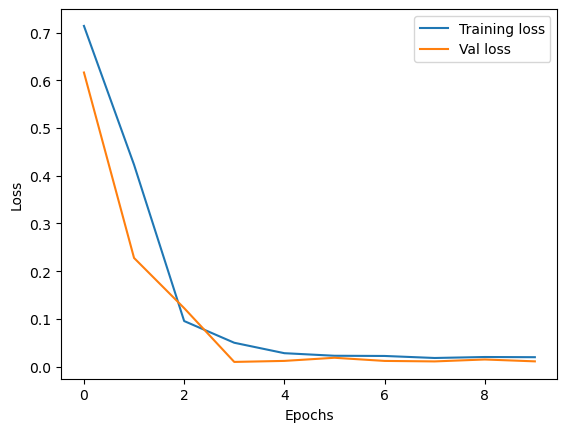

In [29]:
# Write your code here. Add as many boxes as you need.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Use the trained model to make predictions for the test set.

In [30]:
# Write your code here. Add as many boxes as you need.
y_pred = model.predict(X_test_lstm)

y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [31]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

RMSE: 2264.3378967924905
R^2 Score: -2.7731204047181066


Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

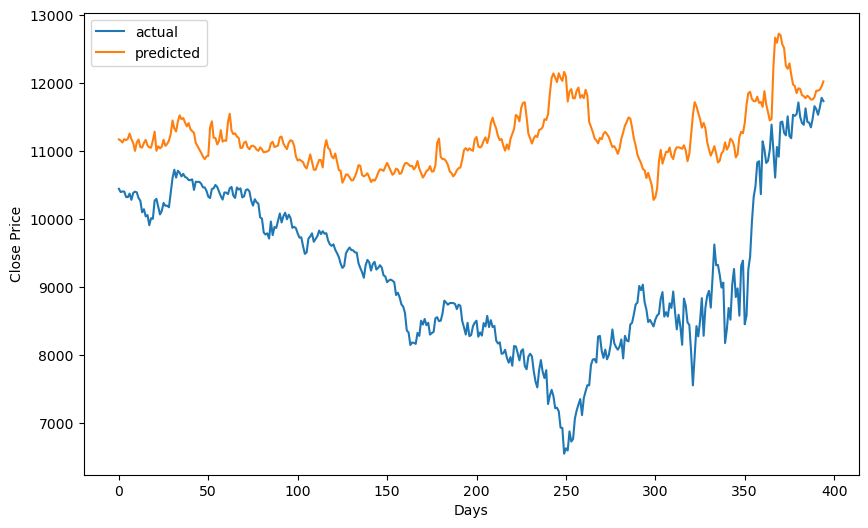

In [32]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(10,6))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()